In [1]:
import cv2
from showimages import showrgb
import numpy as np

### Reading the image

In [2]:
lane1 = cv2.imread("lane1.png")
lane1.shape

(240, 320, 3)

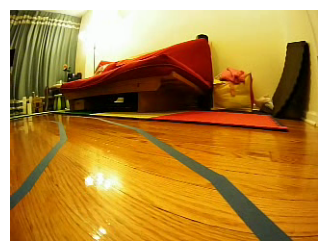

In [3]:
showrgb(lane1)

### Canny

In [4]:
def get_canny(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([22, 0, 0])
    upper_blue = np.array([68, 228, 172])
    mask = cv2.inRange(img_hsv, lower_blue, upper_blue)
    edges = cv2.Canny(mask, 200, 400)
    edges[:img.shape[0] // 2, :] = 0 # crops top half of image
    return edges

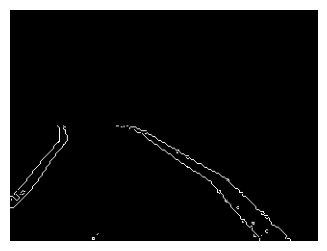

In [5]:
lane1_canny = get_canny(lane1)
showrgb(lane1_canny, save="Lane1_canny")

### Line detection

In [6]:
def get_lines(img):
    lines = cv2.HoughLinesP(img, 1, np.pi / 180, 10, minLineLength= 8, maxLineGap=4)
    return lines

In [7]:
lane1_lines = get_lines(lane1_canny)
lane1_lines.shape, lane1_lines[0].shape

((25, 1, 4), (1, 4))

In [8]:
def draw_lines(img, lines, color=(0, 0, 255), thickness=2):
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    return img

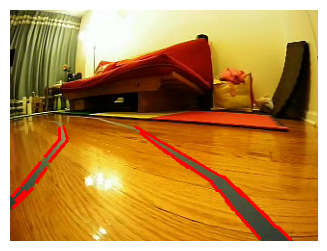

In [10]:
lane1_copy = lane1.copy()
lane1_copy = draw_lines(lane1_copy, lane1_lines)
showrgb(lane1_copy, save="Lane1_segmented")

### Make the lines detected into 2 (or 1) seperate lines

In [11]:
def make_points(img, line):
    h, w, _ = img.shape
    slope, intercept = line
    y1 = h # bottom of image
    y2 = y1 // 2
    x1 = max(-w, min(2 * w, int((y1 - intercept) / slope))) # (y1 - intercept) / slope is solving y = mx + c. Max and min
                                                            # are used to make sure that x1 is within bounds of the frame.
                                                            # while -width is technically outside of the frame, it acts as a
                                                            # "safety buffer" to ensure that any part of the line segment
                                                            # that falls outside of the frame is clipped and not drawn.
    x2 = max(-w, min(2 * w, int((y2 - intercept) / slope)))
    return [[x1, y1, x2, y2]]

def average_slope_intercept(img, line_segments):
    lines = []
    if line_segments is None:
        print("No line segments detected.")
        return lines

    h, w, _ = img.shape
    left_fit = []
    right_fit = []

    boundary = 1 / 3 # left line and right line split from right
    left_region_boundary = w * (1 - boundary)
    right_region_boundary = w * boundary

    for line_segment in line_segments:
        for x1, y1, x2, y2 in line_segment:
            if x1 == x2:
                continue # avoid division by zero
            fit = np.polyfit((x1, x2), (y1, y2), 1) # np.polyfit returns the slope and y-intercept of a line given points
                                                    # 1 is the degree of the polynomial
            slope = fit[0]
            intercept = fit[1]
            if slope < 0:
                if x1 < left_region_boundary and x2 < left_region_boundary: # both points on left side
                    left_fit.append((slope, intercept))
            else:
                if x1 > right_region_boundary and x2 > right_region_boundary: # both points on right side
                    right_fit.append((slope, intercept))
    left_fit_average = np.average(left_fit, axis=0) # average of slope and intercept
    if len(left_fit) > 0:
        lines.append(make_points(img, left_fit_average))
    right_fit_average = np.average(right_fit, axis=0) # average of slope and intercept
    if len(right_fit) > 0:
        lines.append(make_points(img, right_fit_average))
    return lines

In [12]:
def detect_lanes(img):
    img_canny = get_canny(img)
    img_lines = get_lines(img_canny)
    img_lines = average_slope_intercept(img, img_lines)
    return img_lines

In [13]:
lane1_lines = detect_lanes(lane1)
lane1_lines

[[[-26, 240, 68, 120]], [[278, 240, 155, 120]]]

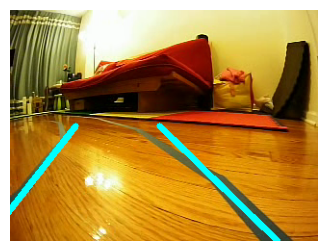

In [14]:
lane1_copy = lane1.copy()
lane1_copy = draw_lines(lane1_copy, lane1_lines, color=(255, 255, 0), thickness=5)
showrgb(lane1_copy, save="Lane1_averaged")

#### Get middle point of the 2 lines

In [15]:
line1, line2 = np.squeeze(lane1_lines) # gets rid of the most outer redundant shape of 1
line1, line2

(array([-26, 240,  68, 120]), array([278, 240, 155, 120]))

In [16]:
x21, x22 = line1[2], line2[2] # x coordinate of the top of the 2 lines
mid = (x21 + x22) // 2
midx = lane1.shape[0] // 2
midy = lane1.shape[1] // 2

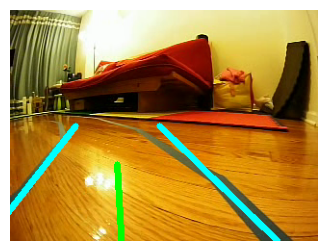

In [17]:
lane1_copy = cv2.line(lane1_copy, (midx, lane1.shape[1]), (mid, midy), (0, 255, 0), 5)
showrgb(lane1_copy, save="Lane1_mid")